<a href="https://colab.research.google.com/github/Felipecordeiiro/Bootcamp-Atlantico/blob/main/Unet_Bootcamp_Atlantico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [30]:
import os
import cv2 as cv
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from keras.utils import normalize
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_dir = '/content/drive/MyDrive/Bootcamp Atlantico/Data/train/image'
mask_dir = '/content/drive/MyDrive/Bootcamp Atlantico/Data/train/mask'

In [5]:
image_listdir = os.listdir(image_dir)
mask_listdir = os.listdir(mask_dir)
random_images = np.random.choice(image_listdir, size = 9, replace = False)

In [6]:
print(len(image_listdir), len(mask_listdir))

80 80


In [7]:
# Definindo o tamanho da imagem
image_size = 512

In [8]:
def image_read(path: str):
  img = cv.imread(path)
  img = cv.resize(img, (image_size, image_size))
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img

In [9]:
number = 200

## Printando as imagens

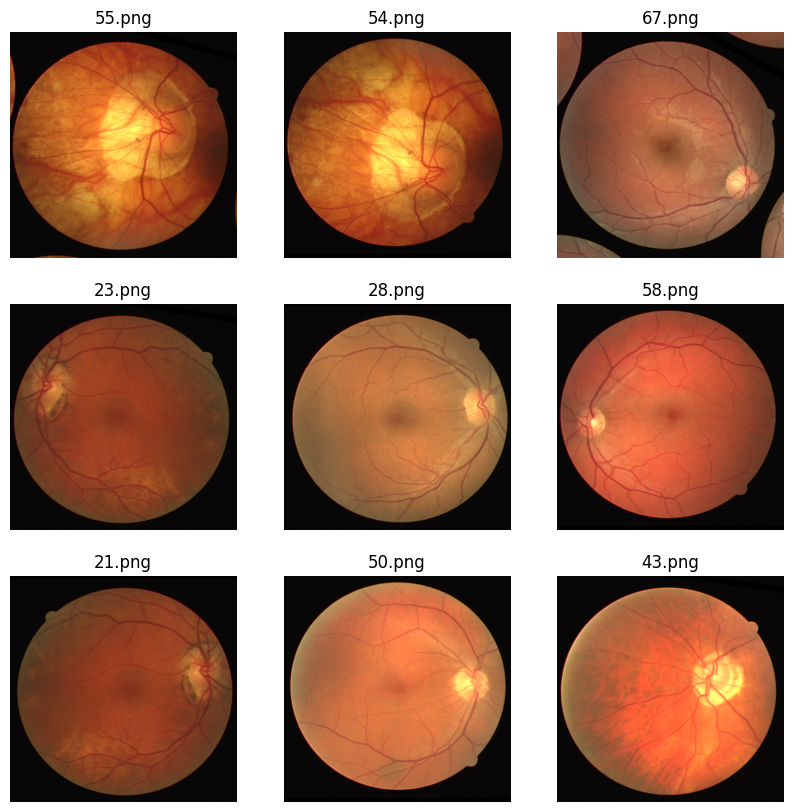

In [10]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = image_read(f"{image_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [12]:
train_image_dataset = []
train_mask_dataset = []
test_image_dataset = []
test_mask_dataset = []

In [24]:
for i, image_name in enumerate(image_listdir):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_dir+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((image_size, image_size))
        train_image_dataset.append(np.array(image))

In [ ]:
for i, image_name in enumerate(mask_listdir):
    if (image_name.split('.')[1] == 'png'):
        print(mask_dir+"/"+image_name)
        image = cv.imread(mask_dir+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((image_size, image_size))
        train_mask_dataset.append(np.array(image))

## Normalização dos dados

In [31]:
#Normalize images
train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.

In [ ]:
image_train, image_test, mask_train, mask_test = train_test_split(
    images, masks, test_size=0.35, random_state=42)

In [ ]:
print(len(image_train), len(image_test), len(mask_train), len(mask_test))

52 28 52 28


# Architecture U-NET

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)

    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="softmax")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), 'AUC'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_51 (Conv2D)          (None, 512, 512, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_50 (Ba  (None, 512, 512, 64)         256       ['conv2d_51[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_50 (Activation)  (None, 512, 512, 64)         0         ['batch_normalization_50[0

In [ ]:
unet_result = unet_model.fit(
    image_train, mask_train,
    validation_split = 0.2,
    batch_size = 4,
    epochs = 20)

Epoch 1/20
11/11 [==============================] - 23s 1s/step - loss: -116.4093 - accuracy: 5.5843e-04 - precision_1: 0.1246 - recall_1: 1.0000 - auc: 0.5000 - val_loss: -23980.4707 - val_accuracy: 5.1706e-04 - val_precision_1: 0.1195 - val_recall_1: 1.0000 - val_auc: 0.5000
Epoch 2/20
11/11 [==============================] - 10s 957ms/step - loss: -257.6508 - accuracy: 5.5843e-04 - precision_1: 0.1246 - recall_1: 1.0000 - auc: 0.5000 - val_loss: -19924.3477 - val_accuracy: 5.1706e-04 - val_precision_1: 0.1195 - val_recall_1: 1.0000 - val_auc: 0.5000
Epoch 3/20
11/11 [==============================] - 11s 966ms/step - loss: -312.5201 - accuracy: 5.5843e-04 - precision_1: 0.1246 - recall_1: 1.0000 - auc: 0.5000 - val_loss: -43.9651 - val_accuracy: 5.1706e-04 - val_precision_1: 0.1195 - val_recall_1: 1.0000 - val_auc: 0.5000
Epoch 4/20
11/11 [==============================] - 11s 1s/step - loss: -349.7192 - accuracy: 5.5843e-04 - precision_1: 0.1246 - recall_1: 1.0000 - auc: 0.5000 - v

# 2º Option

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D,  concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.utils import normalize

In [ ]:
train_mask_dataset = []
train_image_dataset = []
test_image_dataset = []
test_mask_dataset = []

In [ ]:
for i, image_name in enumerate(image_listdir):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_dir+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((512, 512))
        train_image_dataset.append(np.array(image))

In [ ]:
for i, image_name in enumerate(mask_listdir):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_dir+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((512, 512))
        train_mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.

In [ ]:
test_images = os.listdir('/content/drive/MyDrive/Bootcamp Atlantico/Data/test/image')
test_masks = os.listdir('/content/drive/MyDrive/Bootcamp Atlantico/Data/test/mask')

In [ ]:
for i, image_name in enumerate(test_images):
  if (image_name.split('.')[1] == 'png'):
      image = cv.imread(image_dir+"/"+image_name, 0)
      image = Image.fromarray(image)
      image = image.resize((512, 512))
      test_image_dataset.append(np.array(image))

In [ ]:
for i, image_name in enumerate(test_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_dir+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((512, 512))
        test_mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
test_image_dataset = np.expand_dims(normalize(np.array(test_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = simple_unet_model(512, 512, 3)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 512, 512, 16)         448       ['input_5[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 512, 512, 16)         0         ['conv2d_72[0][0]']           
                                                                                                  
 conv2d_73 (Conv2D)          (None, 512, 512, 16)         2320      ['dropout_27[0][0]']          
                                                                                            

In [ ]:
history = model.fit(image_train, mask_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=80,
                    validation_data=(test_image_dataset, test_mask_dataset),
                    shuffle=False)

## Reducing the overfitting

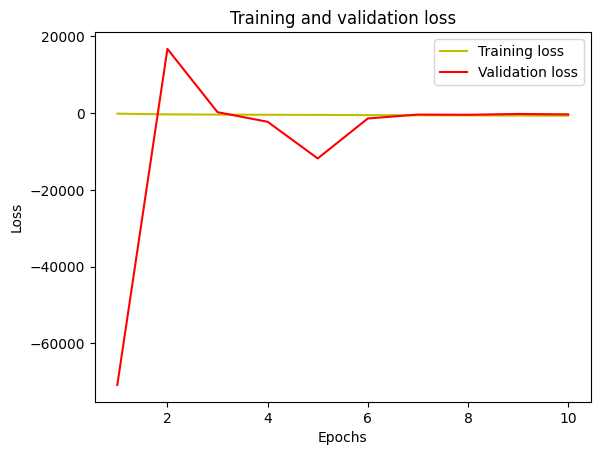

In [ ]:
loss = unet_result.history['loss']
val_loss = unet_result.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()